In [3]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, r2_score, precision_score

In [4]:
#Считывание данных в DataFrame 

df_train = pd.read_csv('/kaggle/input/novosib-gpu-in/train_dataset_train.csv', sep=',', index_col=None,
                       dtype={'id':int, 'Easting':float, 'Northing':float,
                              'Height':float, 'Reflectance':float, 'Class':int})
df_test = pd.read_csv('/kaggle/input/novosib-gpu-in/test_dataset_test.csv', sep=',', index_col=None,
                      dtype={'id':int, 'Easting':float, 'Northing':float,
                            'Height':float, 'Reflectance':float, 'Class':int})

In [ ]:
#Отделение меток от данных

X = df_train[['Easting', 'Northing', 'Height', 'Reflectance']]
y = df_train[['Class']]

In [ ]:
#Разделение на train/test для локального тестирования

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [ ]:
#Создание объекта данных Pool, плюсы: возможность указать какие признаки являются категориальными

pool_train = Pool(X_train, y_train)
pool_test = Pool(X_test)

In [ ]:
#Объявление CatBoostClassifer и обучение

model = CatBoostClassifier(task_type='GPU')
model.fit(pool_train)

In [ ]:
#Получение ответов модели на тестовой выборке в локальном тестировании 

y_pred = model.predict(pool_test)

In [ ]:
model.save_model('/kaggle/working/cat_boost_frac.cbm', format='cbm')

In [ ]:
#Сохраняем в csv файл
 
pd.DataFrame({'id': X_test.index, 'Class': np.squeeze(y_pred.astype(int))}).to_csv(
    '/kaggle/working/cat_boost_classif_train_frac_solution.csv', sep=',', index=None)

In [ ]:
#На локальном тестировании модель выдаёт такой результат
result = recall_score(y_test, y_pred, average='macro', zero_division=True)

print("Recall score",result)

In [ ]:
# R2 метрика скорее больше подходит для числовых, а не категориальных данных
print("Значение метрики R2 на test: ", r2_score(y_test, y_pred))

In [ ]:
#Формируем sample_solution. В обучении используется весь train, ответы получаем на test

pool_train_solution = Pool(X, y)
pool_test_solution = Pool(df_test)

model_solution = CatBoostClassifier(task_type='GPU')
model_solution.fit(pool_train_solution)

In [ ]:
model_solution.save_model('/kaggle/working/cat_boost_full.cbm', format='cbm')

In [ ]:
#Получение ответов

y_pred_solution = model_solution.predict(pool_test_solution)

In [ ]:
#Вот так они выглядят

y_pred_solution.astype(int)

In [ ]:
#Сохраняем в csv файл
 
pd.DataFrame({'id': df_test.id,
              'Class': np.squeeze(y_pred_solution.astype(int))}).to_csv(
    '/kaggle/working/cat_boost_classif_solution.csv', sep=',', index=None)

# Перенос координат (Easting, Northing, Height) сдвигом их минимальных значений в (0, 0, 0), а потом CatBoostClassifier

In [5]:
df_train_zero = df_train.copy()
df_test_zero = df_test.copy()

In [6]:
df_train_zero

,id,Easting,Northing,Height,Reflectance,Class
0,2321251,431696.5375,6.032319e+06,69.2226,-11.14,0
1,3515173,431710.3835,6.032291e+06,68.9711,-15.16,3
2,2320295,431696.8099,6.032322e+06,69.2453,-13.59,0
3,2454459,431680.4542,6.032343e+06,69.1892,-11.21,0
4,4608150,431720.0914,6.032288e+06,67.3252,-9.10,0
...,...,...,...,...,...,...
4222089,2498809,431721.6917,6.032297e+06,69.2220,-9.21,0
4222090,146939,431684.7126,6.032323e+06,67.5003,-9.52,0
4222091,5641497,431735.0991,6.032293e+06,68.9625,-10.30,0
4222092,3833813,431702.1040,6.032318e+06,69.2873,-9.94,0


In [7]:
df_test_zero

,id,Easting,Northing,Height,Reflectance
0,1836965,431754.6192,6.032265e+06,69.2608,-13.99
1,3659389,431654.4141,6.032344e+06,68.0129,-10.99
2,5433033,431686.8574,6.032334e+06,69.2442,-10.26
3,1168709,431711.5747,6.032293e+06,69.6617,-8.25
4,5821779,431728.5806,6.032315e+06,67.6753,-7.56
...,...,...,...,...,...
1809464,2279523,431691.6346,6.032326e+06,69.2069,-11.32
1809465,220720,431712.8414,6.032338e+06,66.8942,-2.79
1809466,3877535,431695.1493,6.032328e+06,69.2111,-4.83
1809467,3389299,431743.6840,6.032275e+06,69.2310,-9.17


In [8]:
df_train_zero.isna().sum()

id             0
Easting        0
Northing       0
Height         0
Reflectance    0
Class          0
dtype: int64

In [9]:
df_test_zero.isna().sum()

id             0
Easting        0
Northing       0
Height         0
Reflectance    0
dtype: int64

In [10]:
min_coord_dict = {coord: df_train_zero[coord].min() for coord in ['Easting', 'Northing', 'Height'] }
min_coord_dict

{'Easting': 431629.442, 'Northing': 6032231.7455, 'Height': 60.4144}

In [11]:
for coord, min_coord_val in min_coord_dict.items():
    df_train_zero[coord] = df_train_zero[coord] - min_coord_val
df_train_zero

,id,Easting,Northing,Height,Reflectance,Class
0,2321251,67.0955,87.7249,8.8082,-11.14,0
1,3515173,80.9415,58.8939,8.5567,-15.16,3
2,2320295,67.3679,90.7160,8.8309,-13.59,0
3,2454459,51.0122,110.8843,8.7748,-11.21,0
4,4608150,90.6494,56.2124,6.9108,-9.10,0
...,...,...,...,...,...,...
4222089,2498809,92.2497,64.9894,8.8076,-9.21,0
4222090,146939,55.2706,90.9605,7.0859,-9.52,0
4222091,5641497,105.6571,61.0520,8.5481,-10.30,0
4222092,3833813,72.6620,86.2217,8.8729,-9.94,0


In [12]:
for coord, min_coord_val in min_coord_dict.items():
    df_test_zero[coord] = df_test_zero[coord] - min_coord_val
df_test_zero

,id,Easting,Northing,Height,Reflectance
0,1836965,125.1772,33.0674,8.8464,-13.99
1,3659389,24.9721,112.6221,7.5985,-10.99
2,5433033,57.4154,101.9300,8.8298,-10.26
3,1168709,82.1327,60.8614,9.2473,-8.25
4,5821779,99.1386,83.0209,7.2609,-7.56
...,...,...,...,...,...
1809464,2279523,62.1926,93.8265,8.7925,-11.32
1809465,220720,83.3994,106.4801,6.4798,-2.79
1809466,3877535,65.7073,95.8333,8.7967,-4.83
1809467,3389299,114.2420,43.3932,8.8166,-9.17


In [14]:
#Отделение меток от данных

X0 = df_train_zero[['Easting', 'Northing', 'Height', 'Reflectance']]
y0 = df_train_zero[['Class']]

In [15]:
#Разделение на train/test для локального тестирования

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.20, random_state=1)

In [17]:
pool0_train = Pool(X0_train, y0_train)
pool0_test = Pool(X0_test)

In [18]:
model0 = CatBoostClassifier(task_type='GPU')
model0.fit(pool0_train)

Learning rate set to 0.340504
0:	learn: 0.8169808	total: 39.1ms	remaining: 39s
1:	learn: 0.6251687	total: 67.5ms	remaining: 33.7s
2:	learn: 0.5077613	total: 97.5ms	remaining: 32.4s
3:	learn: 0.4396905	total: 127ms	remaining: 31.5s
4:	learn: 0.3784335	total: 156ms	remaining: 31s
5:	learn: 0.3394828	total: 187ms	remaining: 30.9s
6:	learn: 0.3099373	total: 217ms	remaining: 30.8s
7:	learn: 0.2921142	total: 258ms	remaining: 32s
8:	learn: 0.2762248	total: 288ms	remaining: 31.7s
9:	learn: 0.2657739	total: 316ms	remaining: 31.3s
10:	learn: 0.2541483	total: 345ms	remaining: 31.1s
11:	learn: 0.2474564	total: 375ms	remaining: 30.8s
12:	learn: 0.2406724	total: 404ms	remaining: 30.7s
13:	learn: 0.2373374	total: 440ms	remaining: 31s
14:	learn: 0.2307677	total: 469ms	remaining: 30.8s
15:	learn: 0.2240102	total: 499ms	remaining: 30.7s
16:	learn: 0.2190114	total: 527ms	remaining: 30.5s
17:	learn: 0.2147439	total: 556ms	remaining: 30.3s
18:	learn: 0.2122575	total: 585ms	remaining: 30.2s
19:	learn: 0.210

In [19]:
y0_pred = model0.predict(pool0_test)

In [20]:
#model0.save_model('/kaggle/working/cat_boost0_frac.cbm', format='cbm')

In [21]:
pd.DataFrame({'id': X0_test.index, 'Class': np.squeeze(y0_pred.astype(int))}).to_csv(
    '/kaggle/working/cat_boost0_classif_train_frac_solution.csv', sep=',', index=None)

In [22]:
#На локальном тестировании модель выдаёт такой результат
result0 = recall_score(y0_test, y0_pred, average='macro', zero_division=True)

print("Recall score",result0)

Recall score 0.8603854932814369


In [23]:
pool0_train_solution = Pool(X0, y0)
pool0_test_solution = Pool(df_test_zero)

model0_solution = CatBoostClassifier(task_type='GPU')
model0_solution.fit(pool0_train_solution)

Learning rate set to 0.356362
0:	learn: 0.7888436	total: 36ms	remaining: 35.9s
1:	learn: 0.6050054	total: 69.2ms	remaining: 34.5s
2:	learn: 0.4797144	total: 104ms	remaining: 34.6s
3:	learn: 0.4104767	total: 141ms	remaining: 35.1s
4:	learn: 0.3617578	total: 174ms	remaining: 34.7s
5:	learn: 0.3316175	total: 207ms	remaining: 34.3s
6:	learn: 0.3056247	total: 243ms	remaining: 34.5s
7:	learn: 0.2896138	total: 275ms	remaining: 34.1s
8:	learn: 0.2716851	total: 314ms	remaining: 34.5s
9:	learn: 0.2605172	total: 348ms	remaining: 34.5s
10:	learn: 0.2516047	total: 382ms	remaining: 34.3s
11:	learn: 0.2401962	total: 416ms	remaining: 34.2s
12:	learn: 0.2344298	total: 453ms	remaining: 34.4s
13:	learn: 0.2292519	total: 486ms	remaining: 34.2s
14:	learn: 0.2245810	total: 520ms	remaining: 34.1s
15:	learn: 0.2176264	total: 554ms	remaining: 34.1s
16:	learn: 0.2154724	total: 586ms	remaining: 33.9s
17:	learn: 0.2130674	total: 620ms	remaining: 33.8s
18:	learn: 0.2077631	total: 653ms	remaining: 33.7s
19:	learn: 

In [24]:
#model0_solution.save_model('/kaggle/working/cat_boost0_full.cbm', format='cbm')

In [25]:
y0_pred_solution = model0_solution.predict(pool0_test_solution)

In [27]:
y0_pred_solution.astype(int)

array([[0],
       [3],
       [0],
       ...,
       [0],
       [0],
       [3]])

In [28]:
pd.DataFrame({'id': df_test.id,
              'Class': np.squeeze(y0_pred_solution.astype(int))}).to_csv(
    '/kaggle/working/cat_boost0_classif_solution.csv', sep=',', index=None)

# Поворот координат (Easting, Northing) на 45 градусов, чтобы получился прямоугольник со сторонами, близко параллельными к осям координат. Далее повтор CatBoostClassifier

In [14]:
# TODO: скорее всего лучше оформить в pipeline, выенести в функции
df_train_zero_45 = df_train_zero.copy()
df_test_zero_45 = df_test_zero.copy()

In [15]:
df_train_zero_45

,id,Easting,Northing,Height,Reflectance,Class
0,2321251,67.0955,87.7249,8.8082,-11.14,0
1,3515173,80.9415,58.8939,8.5567,-15.16,3
2,2320295,67.3679,90.7160,8.8309,-13.59,0
3,2454459,51.0122,110.8843,8.7748,-11.21,0
4,4608150,90.6494,56.2124,6.9108,-9.10,0
...,...,...,...,...,...,...
4222089,2498809,92.2497,64.9894,8.8076,-9.21,0
4222090,146939,55.2706,90.9605,7.0859,-9.52,0
4222091,5641497,105.6571,61.0520,8.5481,-10.30,0
4222092,3833813,72.6620,86.2217,8.8729,-9.94,0


In [16]:
df_test_zero_45

,id,Easting,Northing,Height,Reflectance
0,1836965,125.1772,33.0674,8.8464,-13.99
1,3659389,24.9721,112.6221,7.5985,-10.99
2,5433033,57.4154,101.9300,8.8298,-10.26
3,1168709,82.1327,60.8614,9.2473,-8.25
4,5821779,99.1386,83.0209,7.2609,-7.56
...,...,...,...,...,...
1809464,2279523,62.1926,93.8265,8.7925,-11.32
1809465,220720,83.3994,106.4801,6.4798,-2.79
1809466,3877535,65.7073,95.8333,8.7967,-4.83
1809467,3389299,114.2420,43.3932,8.8166,-9.17


In [18]:
from scipy.spatial.transform import Rotation as R
# Вектор вращения на 45 градусов параллельно оси Height
r = R.from_rotvec(45 * np.array([0, 0, 1]), degrees=True)
r.as_rotvec(degrees=True)

array([ 0.,  0., 45.])

In [19]:
# Матрица вращения
r.as_matrix()

array([[ 0.70710678, -0.70710678,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [20]:
r.apply(df_train_zero_45[['Easting', 'Northing', 'Height']].to_numpy())

array([[-14.58718863, 109.47455471,   8.8082    ],
       [ 15.59000747,  98.87855959,   8.5567    ],
       [-16.50959984, 111.78219769,   8.8309    ],
       ...,
       [ 31.54056869, 117.8811351 ,   8.5481    ],
       [ -9.58815582, 112.34774169,   8.8729    ],
       [-18.15807788, 134.50853892,   6.5133    ]])

In [21]:
df_train_zero_45[['Easting', 'Northing', 'Height']] = r.apply(df_train_zero_45[['Easting', 'Northing', 'Height']].to_numpy())
df_train_zero_45[['Easting', 'Northing', 'Height']]

,Easting,Northing,Height
0,-14.587189,109.474555,8.8082
1,15.590007,98.878560,8.5567
2,-16.509600,111.782198,8.8309
3,-42.335968,114.478113,8.7748
4,24.350636,103.846975,6.9108
...,...,...,...
4222089,19.275943,111.184834,8.8076
4222090,-25.236570,103.401002,7.0859
4222091,31.540569,117.881135,8.5481
4222092,-9.588156,112.347742,8.8729


In [22]:
df_test_zero_45[['Easting', 'Northing', 'Height']] = r.apply(df_test_zero_45[['Easting', 'Northing', 'Height']].to_numpy())
df_test_zero_45[['Easting', 'Northing', 'Height']]

,Easting,Northing,Height
0,65.131464,111.895830,8.8464
1,-61.977909,97.293792,7.5985
2,-31.476576,112.674213,8.8298
3,15.041080,101.112098,9.2473
4,11.396935,128.806218,7.2609
...,...,...,...
1809464,-22.368545,110.322164,8.7925
1809465,-16.320519,134.265082,6.4798
1809466,-21.302299,114.226454,8.7967
1809467,50.097667,111.464919,8.8166


## CatBoostClassifier

In [111]:
X0_45 = df_train_zero_45[['Easting', 'Northing', 'Height', 'Reflectance']]
y0_45 = df_train_zero_45[['Class']]

In [112]:
X0_45_train, X0_45_test, y0_45_train, y0_45_test = train_test_split(X0_45, y0_45, test_size=0.20, random_state=1)

In [113]:
pool0_45_train = Pool(X0_45_train, y0_45_train)
pool0_45_test = Pool(X0_45_test)

In [120]:
model0_45 = CatBoostClassifier(task_type='GPU')
model0_45.fit(pool0_45_train)

Learning rate set to 0.340504
0:	learn: 0.6510268	total: 30.4ms	remaining: 30.3s
1:	learn: 0.4614897	total: 60.4ms	remaining: 30.1s
2:	learn: 0.3536924	total: 88.7ms	remaining: 29.5s
3:	learn: 0.2860474	total: 119ms	remaining: 29.6s
4:	learn: 0.2405281	total: 149ms	remaining: 29.7s
5:	learn: 0.2074383	total: 179ms	remaining: 29.7s
6:	learn: 0.1851321	total: 209ms	remaining: 29.7s
7:	learn: 0.1701880	total: 246ms	remaining: 30.5s
8:	learn: 0.1579364	total: 278ms	remaining: 30.6s
9:	learn: 0.1502267	total: 306ms	remaining: 30.3s
10:	learn: 0.1432357	total: 336ms	remaining: 30.2s
11:	learn: 0.1390789	total: 364ms	remaining: 29.9s
12:	learn: 0.1365287	total: 391ms	remaining: 29.7s
13:	learn: 0.1309680	total: 425ms	remaining: 30s
14:	learn: 0.1285197	total: 452ms	remaining: 29.7s
15:	learn: 0.1254401	total: 482ms	remaining: 29.6s
16:	learn: 0.1243120	total: 512ms	remaining: 29.6s
17:	learn: 0.1235131	total: 541ms	remaining: 29.5s
18:	learn: 0.1192798	total: 570ms	remaining: 29.4s
19:	learn:

In [121]:
y0_45_pred = model0_45.predict(pool0_45_test)

In [122]:
#model0_45.save_model('/kaggle/working/cat_boost0_45_frac.cbm', format='cbm')

In [123]:
pd.DataFrame({'id': X0_45_test.index, 'Class': np.squeeze(y0_45_pred.astype(int))}).to_csv(
    '/kaggle/working/cat_boost0_45_classif_train_frac_solution.csv', sep=',', index=None)

In [124]:
result0_45 = recall_score(y0_45_test, y0_45_pred, average='macro', zero_division=True)

In [125]:
print("Recall score",result0_45)

Recall score 0.882345804209374


In [126]:
pool0_45_train_solution = Pool(X0_45, y0_45)
pool0_45_test_solution = Pool(df_test_zero_45)

In [127]:
model0_45_solution = CatBoostClassifier(task_type='GPU')
model0_45_solution.fit(pool0_45_train_solution)

Learning rate set to 0.356362
0:	learn: 0.6192071	total: 35.8ms	remaining: 35.7s
1:	learn: 0.4367348	total: 69.1ms	remaining: 34.5s
2:	learn: 0.3370133	total: 103ms	remaining: 34.1s
3:	learn: 0.2731867	total: 136ms	remaining: 33.9s
4:	learn: 0.2300646	total: 170ms	remaining: 33.7s
5:	learn: 0.2019237	total: 203ms	remaining: 33.6s
6:	learn: 0.1810842	total: 245ms	remaining: 34.7s
7:	learn: 0.1651460	total: 278ms	remaining: 34.5s
8:	learn: 0.1553317	total: 310ms	remaining: 34.1s
9:	learn: 0.1464696	total: 343ms	remaining: 34s
10:	learn: 0.1418041	total: 376ms	remaining: 33.8s
11:	learn: 0.1373941	total: 415ms	remaining: 34.2s
12:	learn: 0.1349874	total: 450ms	remaining: 34.1s
13:	learn: 0.1260456	total: 482ms	remaining: 34s
14:	learn: 0.1222431	total: 515ms	remaining: 33.8s
15:	learn: 0.1206412	total: 546ms	remaining: 33.6s
16:	learn: 0.1190211	total: 579ms	remaining: 33.5s
17:	learn: 0.1209467	total: 612ms	remaining: 33.4s
18:	learn: 0.1193769	total: 644ms	remaining: 33.2s
19:	learn: 0.

In [128]:
#model0_45_solution.save_model('/kaggle/working/cat_boost0_45_full.cbm', format='cbm')

In [129]:
y0_45_pred_solution = model0_45_solution.predict(pool0_45_test_solution)

In [130]:
y0_45_pred_solution.astype(int)

array([[0],
       [3],
       [0],
       ...,
       [0],
       [0],
       [3]])

In [132]:
pd.DataFrame({'id': df_test_zero_45.id,
              'Class': np.squeeze(y0_45_pred_solution.astype(int))}).to_csv(
    '/kaggle/working/cat_boost0_45_classif_solution.csv', sep=',', index=None)

# Исследование данных после поворота

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import recall_score, precision_score

%matplotlib inline

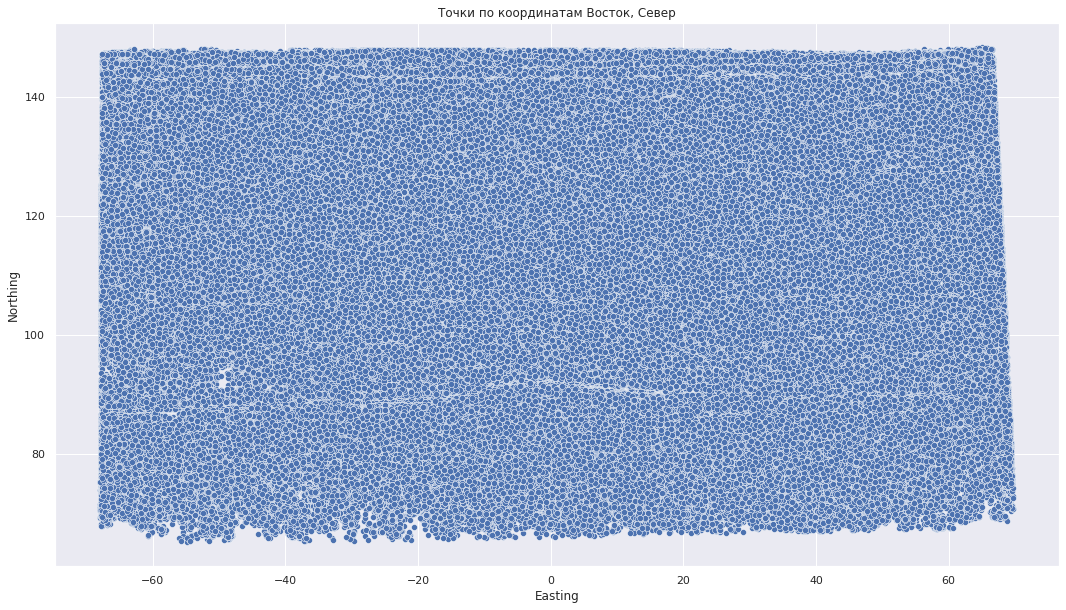

In [33]:
sns.set(rc={'figure.figsize':(18,10)})
sns.scatterplot(data = df_train_zero_45, x= "Easting", y = "Northing").set_title('Точки по координатам Восток, Север');

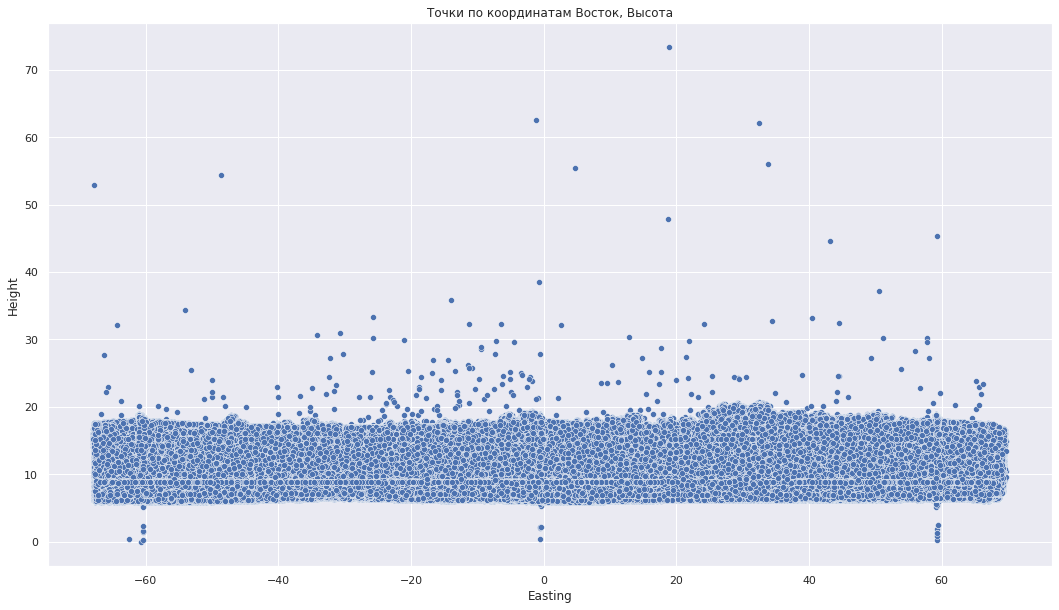

In [34]:
sns.set(rc={'figure.figsize':(18,10)})
sns.scatterplot(data = df_train_zero_45, x= "Easting", y = "Height").set_title('Точки по координатам Восток, Высота');

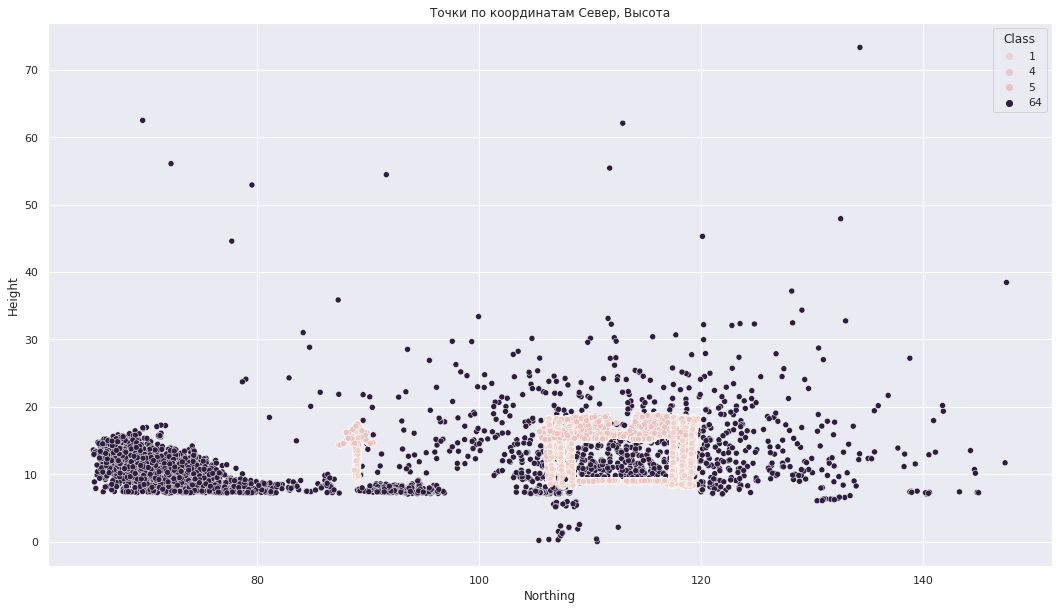

In [35]:
sns.set(rc={'figure.figsize':(18,10)})
sns.scatterplot(data = df_train_zero_45[~df_train_zero_45['Class'].isin([0,3])],
                x= "Northing", y = "Height", hue="Class").set_title(
    'Точки по координатам Север, Высота');

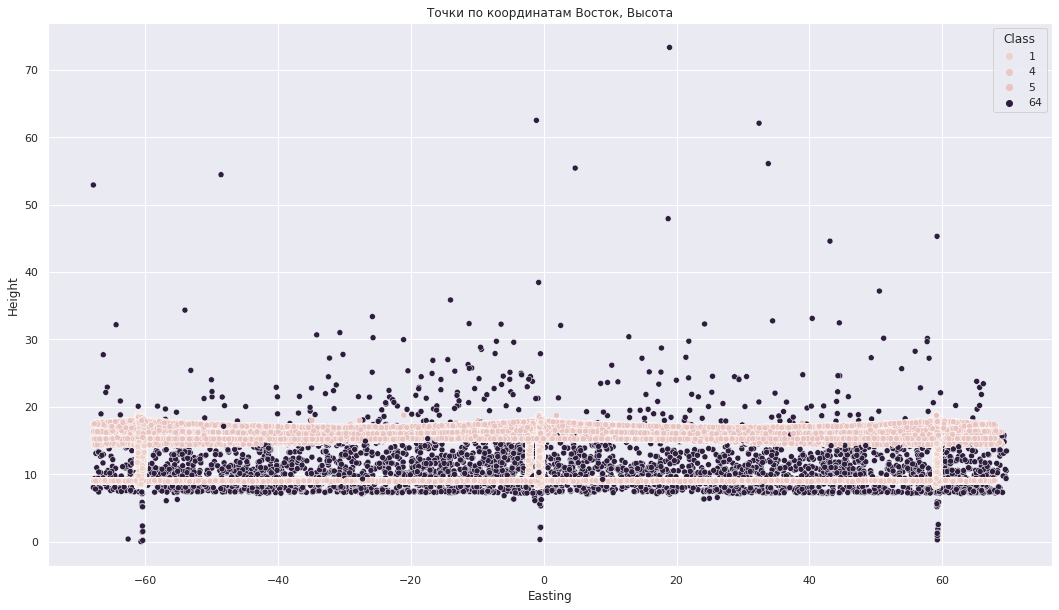

In [36]:
sns.set(rc={'figure.figsize':(18,10)})
sns.scatterplot(data = df_train_zero_45[~df_train_zero_45['Class'].isin([0,3])],
                x= "Easting", y = "Height", hue="Class").set_title(
    'Точки по координатам Восток, Высота');

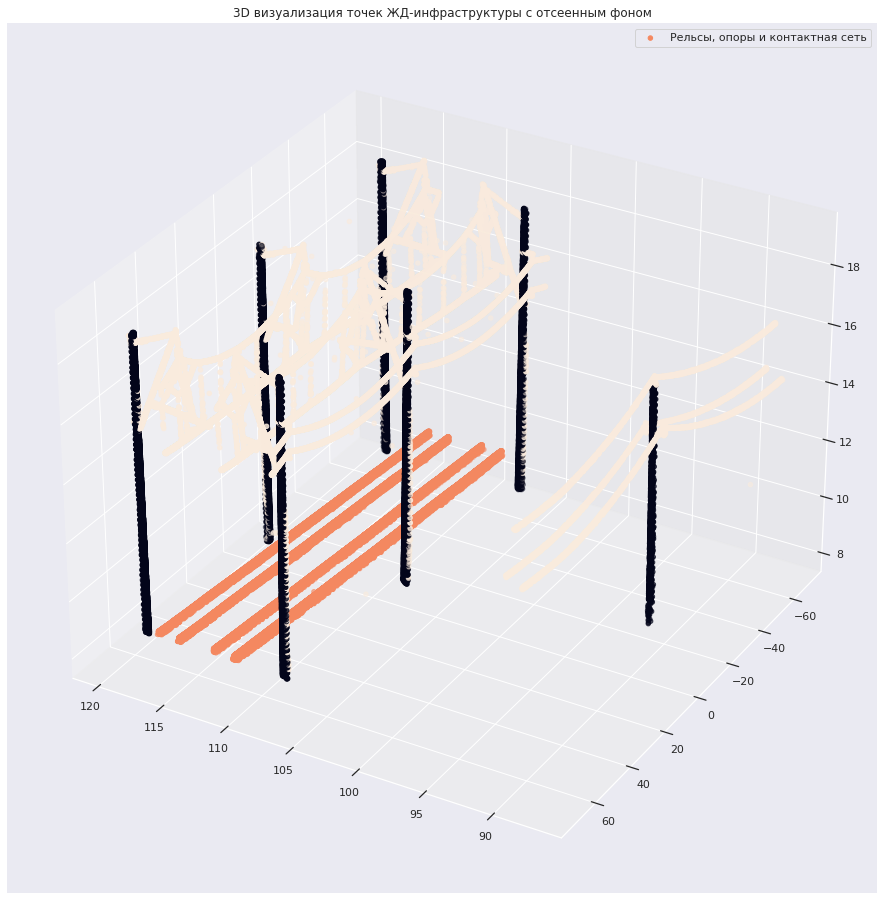

In [41]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(projection='3d')

data_3d = df_train_zero_45[~df_train_zero_45['Class'].isin([0, 3, 64])]

ax.scatter(data_3d['Northing'], data_3d['Easting'], data_3d['Height'], c=data_3d['Class'])

plt.title('3D визуализация точек ЖД-инфраструктуры с отсеенным фоном')

ax.view_init(30, 120)

# TODO: вывести по цветам на разхных строках
plt.legend(['Рельсы, опоры и контактная сеть'])

plt.show()

In [24]:
# Для переноса в (0, 0, 0) используем только точки жд-инфраструктуры с отсеянными землёй, растительностью, шумом
min_coord_for_transform_dict = {coord: df_train_zero_45.loc[~df_train_zero_45['Class'].isin([0, 3, 64]), coord].min()
                                for coord in ['Easting', 'Northing', 'Height'] }
min_coord_for_transform_dict

{'Easting': -67.79266056442818,
 'Northing': 87.33687986459559,
 'Height': 8.117900000000006}

In [25]:
# Снова переносим в (0, 0, 0) для дальнейшей фильтрации выбросов (outlier detection)
df_train_od = df_train_zero_45.copy()
df_train_od

,id,Easting,Northing,Height,Reflectance,Class
0,2321251,-14.587189,109.474555,8.8082,-11.14,0
1,3515173,15.590007,98.878560,8.5567,-15.16,3
2,2320295,-16.509600,111.782198,8.8309,-13.59,0
3,2454459,-42.335968,114.478113,8.7748,-11.21,0
4,4608150,24.350636,103.846975,6.9108,-9.10,0
...,...,...,...,...,...,...
4222089,2498809,19.275943,111.184834,8.8076,-9.21,0
4222090,146939,-25.236570,103.401002,7.0859,-9.52,0
4222091,5641497,31.540569,117.881135,8.5481,-10.30,0
4222092,3833813,-9.588156,112.347742,8.8729,-9.94,0


In [26]:
for coord, min_coord_val in min_coord_for_transform_dict.items():
    df_train_od[coord] = df_train_od[coord] - min_coord_val
df_train_od

,id,Easting,Northing,Height,Reflectance,Class
0,2321251,53.205472,22.137675,0.6903,-11.14,0
1,3515173,83.382668,11.541680,0.4388,-15.16,3
2,2320295,51.283061,24.445318,0.7130,-13.59,0
3,2454459,25.456693,27.141233,0.6569,-11.21,0
4,4608150,92.143297,16.510095,-1.2071,-9.10,0
...,...,...,...,...,...,...
4222089,2498809,87.068604,23.847954,0.6897,-9.21,0
4222090,146939,42.556090,16.064123,-1.0320,-9.52,0
4222091,5641497,99.333229,30.544255,0.4302,-10.30,0
4222092,3833813,58.204505,25.010862,0.7550,-9.94,0


In [71]:
df_train_od.to_csv('/kaggle/working/df_train_od.csv', sep=',', index=False)

In [27]:
df_test_od = df_test_zero_45.copy()
df_test_od

,id,Easting,Northing,Height,Reflectance
0,1836965,65.131464,111.895830,8.8464,-13.99
1,3659389,-61.977909,97.293792,7.5985,-10.99
2,5433033,-31.476576,112.674213,8.8298,-10.26
3,1168709,15.041080,101.112098,9.2473,-8.25
4,5821779,11.396935,128.806218,7.2609,-7.56
...,...,...,...,...,...
1809464,2279523,-22.368545,110.322164,8.7925,-11.32
1809465,220720,-16.320519,134.265082,6.4798,-2.79
1809466,3877535,-21.302299,114.226454,8.7967,-4.83
1809467,3389299,50.097667,111.464919,8.8166,-9.17


In [28]:
for coord, min_coord_val in min_coord_for_transform_dict.items():
    df_test_od[coord] = df_test_od[coord] - min_coord_val
df_test_od

,id,Easting,Northing,Height,Reflectance
0,1836965,132.924125,24.558950,0.7285,-13.99
1,3659389,5.814751,9.956912,-0.5194,-10.99
2,5433033,36.316085,25.337333,0.7119,-10.26
3,1168709,82.833741,13.775218,1.1294,-8.25
4,5821779,79.189596,41.469338,-0.8570,-7.56
...,...,...,...,...,...
1809464,2279523,45.424115,22.985284,0.6746,-11.32
1809465,220720,51.472141,46.928202,-1.6381,-2.79
1809466,3877535,46.490362,26.889574,0.6788,-4.83
1809467,3389299,117.890327,24.128039,0.6987,-9.17


In [74]:
df_test_od.to_csv('/kaggle/working/df_test_od.csv', sep=',', index=False)

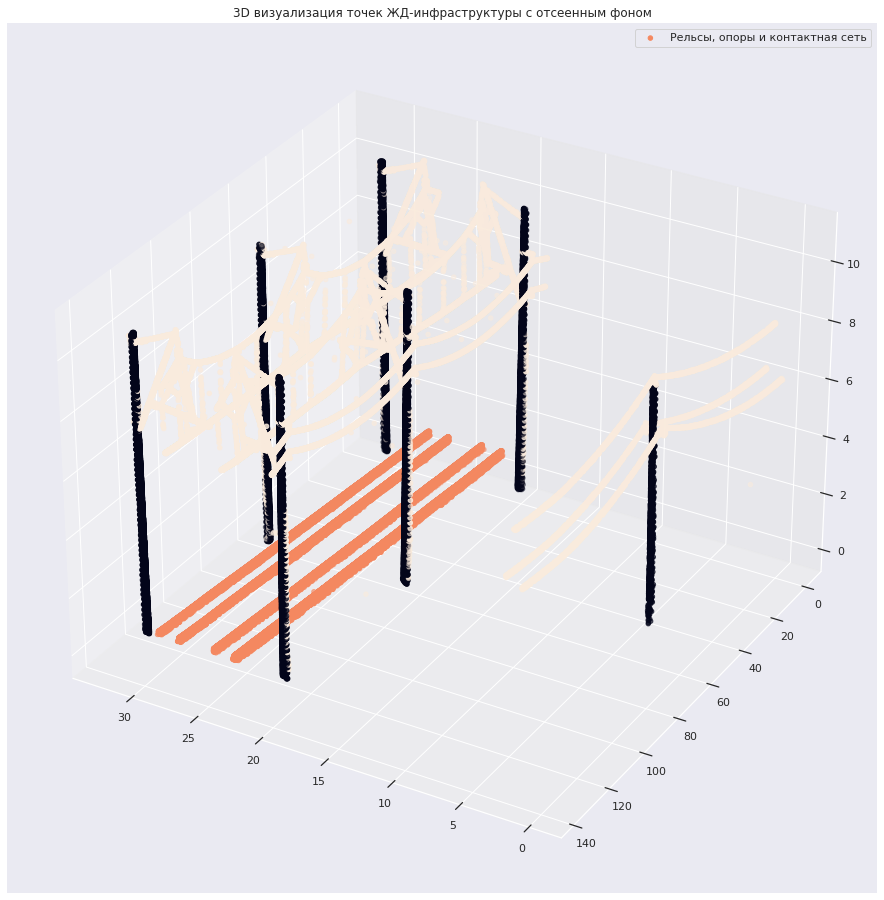

In [75]:
# Снова 3D-картинка

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(projection='3d')

# Фильтруем землю, растительность и шумы, оставляем интересующий сигнал жд-инфраструктуры
data_od_3d = df_train_od[~df_train_od['Class'].isin([0, 3, 64])]

ax.scatter(data_od_3d['Northing'], data_od_3d['Easting'], data_od_3d['Height'], c=data_od_3d['Class'])

plt.title('3D визуализация точек ЖД-инфраструктуры с отсеенным фоном')

ax.view_init(30, 120)

# TODO: вывести по цветам на разхных строках
plt.legend(['Рельсы, опоры и контактная сеть'])

plt.show()

In [29]:
# Для фильтрации выбросов используем только точки жд-инфраструктуры с отсеянными землёй, растительностью, шумом
max_coord_od_dict = {coord: df_train_od.loc[~df_train_od['Class'].isin([0, 3, 64]), coord].max()
                                for coord in ['Easting', 'Northing', 'Height'] }
max_coord_od_dict

{'Easting': 136.80005986886613,
 'Northing': 32.31287071187474,
 'Height': 10.856399999999994}

In [44]:
query = f"Easting>=0 and Easting<={max_coord_od_dict['Easting']} and Northing>=0 and Northing<={max_coord_od_dict['Northing']} and Height>=0 and Height<={max_coord_od_dict['Height']}"
# Фильтруем точки фона. Оставляем лишь параллелепипед с жд-инфраструктурой
df_train_od_filtered = df_train_od.query(query)
df_train_od_filtered

,id,Easting,Northing,Height,Reflectance,Class
0,2321251,53.205472,22.137675,0.6903,-11.14,0
1,3515173,83.382668,11.541680,0.4388,-15.16,3
2,2320295,51.283061,24.445318,0.7130,-13.59,0
3,2454459,25.456693,27.141233,0.6569,-11.21,0
7,3326167,122.969546,24.919221,0.9658,-20.24,4
...,...,...,...,...,...,...
4222086,3884081,49.312566,27.896211,0.6983,-7.20,0
4222088,3560174,62.117351,21.990950,0.6568,-15.06,0
4222089,2498809,87.068604,23.847954,0.6897,-9.21,0
4222091,5641497,99.333229,30.544255,0.4302,-10.30,0


In [78]:
df_train_od_filtered.to_csv('/kaggle/working/df_train_od_filtered.csv', sep=',', index=False)

In [54]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, r2_score, precision_score

# TODO: наверно всё же лучше в pipeline
def cat_boost_clf(df_train_, df_test_, save_file_prefix='solution', num_iter_=1000):
    X_ = df_train_[['Easting', 'Northing', 'Height', 'Reflectance']]
    y_ = df_train_[['Class']]

    #Разделение на train/test для локального тестирования
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.20, random_state=1)

    #Создание объекта данных Pool, плюсы: возможность указать какие признаки являются категориальными
    pool_train_ = Pool(X_train_, y_train_)
    pool_test_ = Pool(X_test_)

    #Объявление CatBoostClassifer и обучение
    # Увеличиваем количество итераций до 2000
    model_ = CatBoostClassifier(task_type='GPU', num_boost_round=num_iter_)
    model_.fit(pool_train_, logging_level='Silent')

    #Получение ответов модели на тестовой выборке в локальном тестировании 
    y_pred_ = model_.predict(pool_test_)

    #model_.save_model(f'/kaggle/working/{save_file_prefix}_cat_boost_frac.cbm', format='cbm')

    #Сохраняем в csv файл
    pd.DataFrame({'id': X_test_.index, 'Class': np.squeeze(y_pred_.astype(int))}).to_csv(
        f'/kaggle/working/{save_file_prefix}_cat_boost_classif_train_frac_solution.csv', sep=',', index=None)

    #На локальном тестировании модель выдаёт такой результат
    result_ = recall_score(y_test_, y_pred_, average='macro', zero_division=True)

    print("Recall score",result_)

    #Формируем sample_solution. В обучении используется весь train, ответы получаем на test
    pool_train_solution_ = Pool(X_, y_)
    pool_test_solution_ = Pool(df_test_)

    # Увеличиваем количество итераций до 2000
    model_solution_ = CatBoostClassifier(task_type='GPU', num_boost_round=num_iter_)
    model_solution_.fit(pool_train_solution_, logging_level='Silent')

    #model_solution_.save_model(f'/kaggle/working/{save_file_prefix}_cat_boost_full.cbm', format='cbm')


    #Получение ответов
    y_pred_solution_ = model_solution_.predict(pool_test_solution_)


    #Вот так они выглядят
    y_pred_solution_.astype(int)


    #Сохраняем в csv файл
    pd.DataFrame({'id': df_test_.id,
                  'Class': np.squeeze(y_pred_solution_.astype(int))}).to_csv(
                    f'/kaggle/working/{save_file_prefix}_cat_boost_classif_solution.csv', sep=',', index=None)

    

In [56]:
# Получилось 0.908 - пока рекорд
cat_boost_clf(df_train_od_filtered, df_test_od, 'rectangle_od', 2000)

Recall score 0.9082491909279287


In [41]:
# Без фильтрации чуть менше: 0.881
cat_boost_clf(df_train_od, df_test_od, 'od')

Recall score 0.8810928749544803


In [32]:
# Попробуем отфильтровать чуть меньше точек по всем сторонам на основе построенных картинок
query = f"Easting>=-2 and Easting<={max_coord_od_dict['Easting']+2} and Northing>=-20 and Northing<={max_coord_od_dict['Northing']+10} and Height>=-2 and Height<={max_coord_od_dict['Height']+5}"
# Фильтруем точки фона. Оставляем лишь параллелепипед с жд-инфраструктурой
df_train_od_filtered_2 = df_train_od.query(query)
df_train_od_filtered_2

,id,Easting,Northing,Height,Reflectance,Class
0,2321251,53.205472,22.137675,0.6903,-11.14,0
1,3515173,83.382668,11.541680,0.4388,-15.16,3
2,2320295,51.283061,24.445318,0.7130,-13.59,0
3,2454459,25.456693,27.141233,0.6569,-11.21,0
4,4608150,92.143297,16.510095,-1.2071,-9.10,0
...,...,...,...,...,...,...
4222088,3560174,62.117351,21.990950,0.6568,-15.06,0
4222089,2498809,87.068604,23.847954,0.6897,-9.21,0
4222090,146939,42.556090,16.064123,-1.0320,-9.52,0
4222091,5641497,99.333229,30.544255,0.4302,-10.30,0


In [40]:
# Получилось те же 0.879 - чуть меньше, чем от всех данных 0.88
cat_boost_clf(df_train_od_filtered_2, df_test_od, 'od_filter_2')

Recall score 0.8798717394800496


In [39]:
# Проверка функции для изначального поворота на 45 градусов
cat_boost_clf(df_train_zero_45, df_test_zero_45, 'rot_45')

Recall score 0.882345804209374


In [59]:
# По картинке в полосе Northing от примерно 7 до 20 тоже нет жд инфраструктуры
# Попробуем убрать и эти точки
query = f"Northing<= 7 or Northing>=20"
df_train_od_filtered_3 = df_train_od_filtered.query(query)
df_train_od_filtered_3

,id,Easting,Northing,Height,Reflectance,Class
0,2321251,53.205472,22.137675,0.6903,-11.14,0
2,2320295,51.283061,24.445318,0.7130,-13.59,0
3,2454459,25.456693,27.141233,0.6569,-11.21,0
7,3326167,122.969546,24.919221,0.9658,-20.24,4
9,390686,104.476583,0.032032,1.0110,-8.53,3
...,...,...,...,...,...,...
4222086,3884081,49.312566,27.896211,0.6983,-7.20,0
4222088,3560174,62.117351,21.990950,0.6568,-15.06,0
4222089,2498809,87.068604,23.847954,0.6897,-9.21,0
4222091,5641497,99.333229,30.544255,0.4302,-10.30,0


In [60]:
# Получилось 0.92 - пока рекорд, но на prod результат уменьшается, наверно всё же нужны все данные
cat_boost_clf(df_train_od_filtered_3, df_test_od, 'od_filtered_3', 2000)
# На prod результат ещё уменьшился, прекращаем фильтрацию данных

Recall score 0.9218454326956724


In [62]:
# Для изначального поворота на 45 градусов с увеличением числа итераций
cat_boost_clf(df_train_zero_45, df_test_zero_45, 'rot_45_more_iter', 4000)

Recall score 0.8812768303894886


In [63]:
cat_boost_clf(df_train_od, df_test_od, 'od_more_iter', 2000)

Recall score 0.8825023678640296


In [64]:
# Попробуем поворот исходных данных на немного другой угол, например 40 градусов
df_train_zero_40 = df_train_zero.copy()
df_test_zero_40 = df_test_zero.copy()

In [65]:
df_train_zero_40

,id,Easting,Northing,Height,Reflectance,Class
0,2321251,67.0955,87.7249,8.8082,-11.14,0
1,3515173,80.9415,58.8939,8.5567,-15.16,3
2,2320295,67.3679,90.7160,8.8309,-13.59,0
3,2454459,51.0122,110.8843,8.7748,-11.21,0
4,4608150,90.6494,56.2124,6.9108,-9.10,0
...,...,...,...,...,...,...
4222089,2498809,92.2497,64.9894,8.8076,-9.21,0
4222090,146939,55.2706,90.9605,7.0859,-9.52,0
4222091,5641497,105.6571,61.0520,8.5481,-10.30,0
4222092,3833813,72.6620,86.2217,8.8729,-9.94,0


In [66]:
df_test_zero_40

,id,Easting,Northing,Height,Reflectance
0,1836965,125.1772,33.0674,8.8464,-13.99
1,3659389,24.9721,112.6221,7.5985,-10.99
2,5433033,57.4154,101.9300,8.8298,-10.26
3,1168709,82.1327,60.8614,9.2473,-8.25
4,5821779,99.1386,83.0209,7.2609,-7.56
...,...,...,...,...,...
1809464,2279523,62.1926,93.8265,8.7925,-11.32
1809465,220720,83.3994,106.4801,6.4798,-2.79
1809466,3877535,65.7073,95.8333,8.7967,-4.83
1809467,3389299,114.2420,43.3932,8.8166,-9.17


In [67]:
from scipy.spatial.transform import Rotation as R
# Вектор вращения на 40 градусов параллельно оси Height
r = R.from_rotvec(40 * np.array([0, 0, 1]), degrees=True)
r.as_rotvec(degrees=True)

array([ 0.,  0., 40.])

In [68]:
# Матрица вращения
r.as_matrix()

array([[ 0.76604444, -0.64278761,  0.        ],
       [ 0.64278761,  0.76604444,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [69]:
r.apply(df_train_zero_40[['Easting', 'Northing', 'Height']].to_numpy())

array([[ -4.99034385, 110.32932823,   8.8082    ],
       [ 24.14851709,  97.14353814,   8.5567    ],
       [ -6.70431536, 112.79573911,   8.8309    ],
       ...,
       [ 41.69456518, 114.6836201 ,   8.5481    ],
       [  0.24008088, 112.75588746,   8.8729    ],
       [ -6.36578929, 135.57927409,   6.5133    ]])

In [70]:
df_train_zero_40[['Easting', 'Northing', 'Height']] = r.apply(df_train_zero_40[['Easting', 'Northing', 'Height']].to_numpy())
df_train_zero_40[['Easting', 'Northing', 'Height']]

,Easting,Northing,Height
0,-4.990344,110.329328,8.8082
1,24.148517,97.143538,8.5567
2,-6.704315,112.795739,8.8309
3,-32.197442,117.732312,8.7748
4,33.308835,101.329508,6.9108
...,...,...,...
4222089,28.892989,109.081733,8.8076
4222090,-16.128546,105.207042,7.0859
4222091,41.694565,114.683620,8.5481
4222092,0.240081,112.755887,8.8729


In [71]:
df_test_zero_40[['Easting', 'Northing', 'Height']] = r.apply(df_test_zero_40[['Easting', 'Northing', 'Height']].to_numpy())
df_test_zero_40[['Easting', 'Northing', 'Height']]

,Easting,Northing,Height
0,74.635983,105.793451,8.8464
1,-53.262352,102.325290,7.5985
2,-21.536593,114.988818,8.8298
3,23.796345,99.416419,9.2473
4,22.579768,127.322763,7.2609
...,...,...,...
1809464,-12.668216,111.851902,8.7925
1809465,-4.556442,135.176590,6.4798
1809466,-11.265746,115.648405,8.7967
1809467,59.621838,106.674462,8.8166


In [72]:
# Recall Меньше, чем при повороте на 45 градусов
cat_boost_clf(df_train_zero_40, df_test_zero_40, 'rot_40_more_iter', 2000)

Recall score 0.8737291197620974


In [73]:
from scipy.spatial.transform import Rotation as R

def rotate_coord(df_dataset, angle):
    # Вектор вращения на angle градусов параллельно оси Height
    r = R.from_rotvec(angle * np.array([0, 0, 1]), degrees=True)
    print(r.as_rotvec(degrees=True))
    # Матрица вращения
    print(r.as_matrix())
    df_dataset[['Easting', 'Northing', 'Height']] = r.apply(df_dataset[['Easting', 'Northing', 'Height']].to_numpy())
    df_dataset[['Easting', 'Northing', 'Height']]
    
    return df_dataset

In [74]:
df_train_rot_50 = rotate_coord(df_train_zero.copy(), 50)
df_train_rot_50

[ 0.  0. 50.]
[[ 0.64278761 -0.76604444  0.        ]
 [ 0.76604444  0.64278761  0.        ]
 [ 0.          0.          1.        ]]


,id,Easting,Northing,Height,Reflectance,Class
0,2321251,-24.073016,107.786614,8.8082,-11.14,0
1,3515173,6.912848,99.861055,8.5567,-15.16,3
2,2320295,-26.189236,109.917926,8.8309,-13.59,0
3,2454459,-52.152292,110.352666,8.7748,-11.21,0
4,4608150,15.207114,105.574103,6.9108,-9.10,0
...,...,...,...,...,...,...
4222089,2498809,9.512195,112.441751,8.8076,-9.21,0
4222090,146939,-34.152529,100.808018,7.0859,-9.52,0
4222091,5641497,21.146529,120.181503,8.5481,-10.30,0
4222092,3833813,-19.343421,111.084562,8.8729,-9.94,0


In [75]:
df_test_rot_50 = rotate_coord(df_test_zero.copy(), 50)
df_test_rot_50

[ 0.  0. 50.]
[[ 0.64278761 -0.76604444  0.        ]
 [ 0.76604444  0.64278761  0.        ]
 [ 0.          0.          1.        ]]


,id,Easting,Northing,Height,Reflectance
0,1836965,55.131255,117.146613,8.8464,-13.99
1,3659389,-70.221777,91.521829,7.5985,-10.99
2,5433033,-41.177002,109.502089,8.8298,-10.26
3,1168709,6.171345,102.038252,9.2473,-8.25
4,5821779,0.127365,129.309379,7.2609,-7.56
...,...,...,...,...,...
1809464,2279523,-31.898636,107.952807,8.7925,-11.32
1809465,220720,-27.960388,132.331736,6.4798,-2.79
1809466,3877535,-31.176729,111.935170,8.7967,-4.83
1809467,3389299,40.192222,115.407061,8.8166,-9.17


In [78]:
# Recall Меньше, чем при повороте на 45 градусов
cat_boost_clf(df_train_rot_50, df_test_rot_50, 'rot_50_more_iter', 2000)

Recall score 0.8744375954901596


In [79]:
df_train_rot_135 = rotate_coord(df_train_zero.copy(), 135)
df_train_rot_135

[  0.   0. 135.]
[[-0.70710678 -0.70710678  0.        ]
 [ 0.70710678 -0.70710678  0.        ]
 [ 0.          0.          1.        ]]


,id,Easting,Northing,Height,Reflectance,Class
0,2321251,-109.474555,-14.587189,8.8082,-11.14,0
1,3515173,-98.878560,15.590007,8.5567,-15.16,3
2,2320295,-111.782198,-16.509600,8.8309,-13.59,0
3,2454459,-114.478113,-42.335968,8.7748,-11.21,0
4,4608150,-103.846975,24.350636,6.9108,-9.10,0
...,...,...,...,...,...,...
4222089,2498809,-111.184834,19.275943,8.8076,-9.21,0
4222090,146939,-103.401002,-25.236570,7.0859,-9.52,0
4222091,5641497,-117.881135,31.540569,8.5481,-10.30,0
4222092,3833813,-112.347742,-9.588156,8.8729,-9.94,0


In [80]:
df_test_rot_135 = rotate_coord(df_test_zero.copy(), 135)
df_test_rot_135

[  0.   0. 135.]
[[-0.70710678 -0.70710678  0.        ]
 [ 0.70710678 -0.70710678  0.        ]
 [ 0.          0.          1.        ]]


,id,Easting,Northing,Height,Reflectance
0,1836965,-111.895830,65.131464,8.8464,-13.99
1,3659389,-97.293792,-61.977909,7.5985,-10.99
2,5433033,-112.674213,-31.476576,8.8298,-10.26
3,1168709,-101.112098,15.041080,9.2473,-8.25
4,5821779,-128.806218,11.396935,7.2609,-7.56
...,...,...,...,...,...
1809464,2279523,-110.322164,-22.368545,8.7925,-11.32
1809465,220720,-134.265082,-16.320519,6.4798,-2.79
1809466,3877535,-114.226454,-21.302299,8.7967,-4.83
1809467,3389299,-111.464919,50.097667,8.8166,-9.17


In [81]:
# Recall почти такой же как и при повороте на 45 градусов, чуть-чуть больше
cat_boost_clf(df_train_rot_135, df_test_rot_135, 'rot_135_more_iter', 2000)

Recall score 0.8816605945122277


In [82]:
df_train_rot_225 = rotate_coord(df_train_zero.copy(), 225)
df_train_rot_225

[  -0.   -0. -135.]
[[-0.70710678  0.70710678  0.        ]
 [-0.70710678 -0.70710678  0.        ]
 [ 0.          0.          1.        ]]


,id,Easting,Northing,Height,Reflectance,Class
0,2321251,14.587189,-109.474555,8.8082,-11.14,0
1,3515173,-15.590007,-98.878560,8.5567,-15.16,3
2,2320295,16.509600,-111.782198,8.8309,-13.59,0
3,2454459,42.335968,-114.478113,8.7748,-11.21,0
4,4608150,-24.350636,-103.846975,6.9108,-9.10,0
...,...,...,...,...,...,...
4222089,2498809,-19.275943,-111.184834,8.8076,-9.21,0
4222090,146939,25.236570,-103.401002,7.0859,-9.52,0
4222091,5641497,-31.540569,-117.881135,8.5481,-10.30,0
4222092,3833813,9.588156,-112.347742,8.8729,-9.94,0


In [85]:
df_test_rot_225 = rotate_coord(df_test_zero.copy(), 225)
df_test_rot_225

[  -0.   -0. -135.]
[[-0.70710678  0.70710678  0.        ]
 [-0.70710678 -0.70710678  0.        ]
 [ 0.          0.          1.        ]]


,id,Easting,Northing,Height,Reflectance
0,1836965,-65.131464,-111.895830,8.8464,-13.99
1,3659389,61.977909,-97.293792,7.5985,-10.99
2,5433033,31.476576,-112.674213,8.8298,-10.26
3,1168709,-15.041080,-101.112098,9.2473,-8.25
4,5821779,-11.396935,-128.806218,7.2609,-7.56
...,...,...,...,...,...
1809464,2279523,22.368545,-110.322164,8.7925,-11.32
1809465,220720,16.320519,-134.265082,6.4798,-2.79
1809466,3877535,21.302299,-114.226454,8.7967,-4.83
1809467,3389299,-50.097667,-111.464919,8.8166,-9.17


In [86]:
# Recall почти такой же как и при повороте на 45 градусов, чуть-чуть больше, пока рекордное значение
cat_boost_clf(df_train_rot_225, df_test_rot_225, 'rot_225_more_iter', 2000)

Recall score 0.8820400690721515


In [87]:
df_train_rot_315 = rotate_coord(df_train_zero.copy(), 315)
df_train_rot_315

[ -0.  -0. -45.]
[[ 0.70710678  0.70710678  0.        ]
 [-0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]


,id,Easting,Northing,Height,Reflectance,Class
0,2321251,109.474555,14.587189,8.8082,-11.14,0
1,3515173,98.878560,-15.590007,8.5567,-15.16,3
2,2320295,111.782198,16.509600,8.8309,-13.59,0
3,2454459,114.478113,42.335968,8.7748,-11.21,0
4,4608150,103.846975,-24.350636,6.9108,-9.10,0
...,...,...,...,...,...,...
4222089,2498809,111.184834,-19.275943,8.8076,-9.21,0
4222090,146939,103.401002,25.236570,7.0859,-9.52,0
4222091,5641497,117.881135,-31.540569,8.5481,-10.30,0
4222092,3833813,112.347742,9.588156,8.8729,-9.94,0


In [88]:
df_test_rot_315 = rotate_coord(df_test_zero.copy(), 315)
df_test_rot_315

[ -0.  -0. -45.]
[[ 0.70710678  0.70710678  0.        ]
 [-0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]


,id,Easting,Northing,Height,Reflectance
0,1836965,111.895830,-65.131464,8.8464,-13.99
1,3659389,97.293792,61.977909,7.5985,-10.99
2,5433033,112.674213,31.476576,8.8298,-10.26
3,1168709,101.112098,-15.041080,9.2473,-8.25
4,5821779,128.806218,-11.396935,7.2609,-7.56
...,...,...,...,...,...
1809464,2279523,110.322164,22.368545,8.7925,-11.32
1809465,220720,134.265082,16.320519,6.4798,-2.79
1809466,3877535,114.226454,21.302299,8.7967,-4.83
1809467,3389299,111.464919,-50.097667,8.8166,-9.17


In [89]:
# Recall почти такой же как и при повороте на 45 градусов, но чуть меньше
cat_boost_clf(df_train_rot_315, df_test_rot_315, 'rot_315_more_iter', 2000)

Recall score 0.8808450543050972


In [90]:
# Покрутим немного возле поворота 225 градусов, давшего рекордный recall 0.882
df_train_rot_227 = rotate_coord(df_train_zero.copy(), 227)
df_train_rot_227

[  -0.   -0. -133.]
[[-0.68199836  0.7313537   0.        ]
 [-0.7313537  -0.68199836  0.        ]
 [ 0.          0.          1.        ]]


,id,Easting,Northing,Height,Reflectance,Class
0,2321251,18.398909,-108.898780,8.8082,-11.14,0
1,3515173,-12.129698,-99.362409,8.5567,-15.16,3
2,2320295,20.400685,-111.137926,8.8309,-13.59,0
3,2454459,46.305407,-112.930872,8.7748,-11.21,0
4,4608150,-20.711595,-104.633539,6.9108,-9.10,0
...,...,...,...,...,...,...
4222089,2498809,-15.383906,-111.789824,8.8076,-9.21,0
4222090,146939,28.829840,-102.457270,7.0859,-9.52,0
4222091,5641497,-27.407363,-118.910075,8.5481,-10.30,0
4222092,3833813,13.503195,-111.944681,8.8729,-9.94,0


In [91]:
df_test_rot_227 = rotate_coord(df_test_zero.copy(), 227)
df_test_rot_227

[  -0.   -0. -133.]
[[-0.68199836  0.7313537   0.        ]
 [-0.7313537  -0.68199836  0.        ]
 [ 0.          0.          1.        ]]


,id,Easting,Northing,Height,Reflectance
0,1836965,-61.186680,-114.100721,8.8464,-13.99
1,3659389,65.335658,-95.071525,7.5985,-10.99
2,5433033,35.389674,-111.507058,8.8298,-10.26
3,1168709,-11.503157,-101.575429,9.2473,-8.25
4,5821779,-6.894720,-129.125500,7.2609,-7.56
...,...,...,...,...,...
1809464,2279523,26.205107,-109.474307,8.7925,-11.32
1809465,220720,20.996361,-133.613713,6.4798,-2.79
1809466,3877535,25.275768,-113.413431,8.7967,-4.83
1809467,3389299,-46.177079,-113.145401,8.8166,-9.17


In [98]:
# Recall почти такой же как и при повороте на 45 градусов, но чуть меньше
cat_boost_clf(df_train_rot_227, df_test_rot_227, 'rot_227', 2000)

Recall score 0.8817151497154194


In [94]:
df_train_rot_226 = rotate_coord(df_train_zero.copy(), 226)
df_train_rot_226

[  -0.   -0. -134.]
[[-0.69465837  0.7193398   0.        ]
 [-0.7193398  -0.69465837  0.        ]
 [ 0.          0.          1.        ]]


,id,Easting,Northing,Height,Reflectance,Class
0,2321251,16.495561,-109.203300,8.8082,-11.14,0
1,3515173,-13.861964,-99.135583,8.5567,-15.16,3
2,2320295,18.457954,-111.477040,8.8309,-13.59,0
3,2454459,44.327438,-113.721813,8.7748,-11.21,0
4,4608150,-22.534548,-104.256135,6.9108,-9.10,0
...,...,...,...,...,...,...
4222089,2498809,-17.332564,-111.504311,8.8076,-9.21,0
4222090,146939,27.037323,-102.944815,7.0859,-9.52,0
4222091,5641497,-29.478455,-118.413640,8.5481,-10.30,0
4222092,3833813,11.547434,-112.163294,8.8729,-9.94,0


In [95]:
df_test_rot_226 = rotate_coord(df_test_zero.copy(), 226)
df_test_rot_226

[  -0.   -0. -134.]
[[-0.69465837  0.7193398   0.        ]
 [-0.7193398  -0.69465837  0.        ]
 [ 0.          0.          1.        ]]


,id,Easting,Northing,Height,Reflectance
0,1836965,-63.168693,-113.015488,8.8464,-13.99
1,3659389,63.666481,-96.197310,7.5985,-10.99
2,5433033,33.438218,-112.107710,8.8298,-10.26
3,1168709,-13.274140,-101.359201,9.2473,-8.25
4,5821779,-9.147221,-128.985504,7.2609,-7.56
...,...,...,...,...,...
1809464,2279523,24.290526,-109.914976,8.7925,-11.32
1809465,220720,18.661283,-133.959800,6.4798,-2.79
1809466,3877535,23.292581,-113.837280,8.7967,-4.83
1809467,3389299,-48.144706,-112.322267,8.8166,-9.17


In [96]:
# Recall почти такой же как и при повороте на 45 градусов, вроде бы рекордный
cat_boost_clf(df_train_rot_226, df_test_rot_226, 'rot_226_more_iter', 2000)

Recall score 0.8824841672579097


In [97]:
df_train_rot_224 = rotate_coord(df_train_zero.copy(), 224)
df_train_rot_224

[  -0.   -0. -136.]
[[-0.7193398   0.69465837  0.        ]
 [-0.69465837 -0.7193398   0.        ]
 [ 0.          0.          1.        ]]


,id,Easting,Northing,Height,Reflectance,Class
0,2321251,12.674373,-109.712463,8.8082,-11.14,0
1,3515173,-17.313302,-98.591417,8.5567,-15.16,3
2,2320295,14.556217,-112.053305,8.8309,-13.59,0
3,2454459,40.331601,-115.199542,8.7748,-11.21,0
4,4608150,-26.159307,-103.406181,6.9108,-9.10,0
...,...,...,...,...,...,...
4222089,2498809,-21.213450,-110.831488,8.8076,-9.21,0
4222090,146939,23.428130,-103.825693,7.0859,-9.52,0
4222091,5641497,-33.593074,-117.312722,8.5481,-10.30,0
4222092,3833813,7.625957,-112.497967,8.8729,-9.94,0


In [99]:
df_test_rot_224 = rotate_coord(df_test_zero.copy(), 224)
df_test_rot_224

[  -0.   -0. -136.]
[[-0.7193398   0.69465837  0.        ]
 [-0.69465837 -0.7193398   0.        ]
 [ 0.          0.          1.        ]]


,id,Easting,Northing,Height,Reflectance
0,1836965,-67.074396,-110.742087,8.8464,-13.99
1,3659389,60.270459,-98.360637,7.5985,-10.99
2,5433033,29.505345,-113.206394,8.8298,-10.26
3,1168709,-16.803439,-100.834195,9.2473,-8.25
4,5821779,-13.643178,-128.587696,7.2609,-7.56
...,...,...,...,...,...
1809464,2279523,20.439751,-110.695746,8.7925,-11.32
1809465,220720,13.974785,-134.529465,6.4798,-2.79
1809466,3877535,19.305528,-114.580833,8.7967,-4.83
1809467,3389299,-52.035368,-110.573617,8.8166,-9.17


In [100]:
# Recall почти такой же как и при повороте на 45 градусов, снова вроде бы рекордный
cat_boost_clf(df_train_rot_224, df_test_rot_224, 'rot_224_more_iter', 2000)

Recall score 0.8835688831868861


In [101]:
df_train_rot_223 = rotate_coord(df_train_zero.copy(), 223)
df_train_rot_223

[  -0.   -0. -137.]
[[-0.7313537   0.68199836  0.        ]
 [-0.68199836 -0.7313537   0.        ]
 [ 0.          0.          1.        ]]


,id,Easting,Northing,Height,Reflectance,Class
0,2321251,10.757696,-109.916951,8.8082,-11.14,0
1,3515173,-19.031322,-98.274242,8.5567,-15.16,3
2,2320295,12.598400,-112.290280,8.8309,-13.59,0
3,2454459,38.314949,-115.885880,8.7748,-11.21,0
4,4608150,-27.960010,-102.933889,6.9108,-9.10,0
...,...,...,...,...,...,...
4222089,2498809,-23.144495,-110.444382,8.8076,-9.21,0
4222090,146939,21.612554,-104.218757,7.0859,-9.52,0
4222091,5641497,-35.635347,-116.708575,8.5481,-10.30,0
4222092,3833813,5.661435,-112.613924,8.8729,-9.94,0


In [102]:
df_test_rot_223 = rotate_coord(df_test_zero.copy(), 223)
df_test_rot_223

[  -0.   -0. -137.]
[[-0.7313537   0.68199836  0.        ]
 [-0.68199836 -0.7313537   0.        ]
 [ 0.          0.          1.        ]]


,id,Easting,Northing,Height,Reflectance
0,1836965,-68.996896,-109.554611,8.8464,-13.99
1,3659389,58.544650,-99.397521,7.5985,-10.99
2,5433033,27.525128,-113.704091,8.8298,-10.26
3,1168709,-18.560679,-100.525577,9.2473,-8.25
4,5821779,-15.885264,-128.330005,7.2609,-7.56
...,...,...,...,...,...
1809464,2279523,18.504731,-111.035609,8.7925,-11.32
1809465,220720,11.624794,-134.752869,6.4798,-2.79
1809466,3877535,17.302876,-114.900310,8.7967,-4.83
1809467,3389299,-53.957218,-109.648634,8.8166,-9.17


In [103]:
# Recall почти такой же как и при повороте на 45 градусов, но чуть меньше
cat_boost_clf(df_train_rot_223, df_test_rot_223, 'rot_223_more_iter', 2000)

Recall score 0.8790835158090582


# Рекордный результат выдал поворот на 224 градуса

# XGBoost для поворота данных на 224 градуса

In [6]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
df_xgb_train = df_train_rot_224.copy()
df_xgb_train

,id,Easting,Northing,Height,Reflectance,Class
0,2321251,12.674373,-109.712463,8.8082,-11.14,0
1,3515173,-17.313302,-98.591417,8.5567,-15.16,3
2,2320295,14.556217,-112.053305,8.8309,-13.59,0
3,2454459,40.331601,-115.199542,8.7748,-11.21,0
4,4608150,-26.159307,-103.406181,6.9108,-9.10,0
...,...,...,...,...,...,...
4222089,2498809,-21.213450,-110.831488,8.8076,-9.21,0
4222090,146939,23.428130,-103.825693,7.0859,-9.52,0
4222091,5641497,-33.593074,-117.312722,8.5481,-10.30,0
4222092,3833813,7.625957,-112.497967,8.8729,-9.94,0


In [8]:
df_xgb_test = df_test_rot_224.copy()
df_xgb_test

,id,Easting,Northing,Height,Reflectance
0,1836965,-67.074396,-110.742087,8.8464,-13.99
1,3659389,60.270459,-98.360637,7.5985,-10.99
2,5433033,29.505345,-113.206394,8.8298,-10.26
3,1168709,-16.803439,-100.834195,9.2473,-8.25
4,5821779,-13.643178,-128.587696,7.2609,-7.56
...,...,...,...,...,...
1809464,2279523,20.439751,-110.695746,8.7925,-11.32
1809465,220720,13.974785,-134.529465,6.4798,-2.79
1809466,3877535,19.305528,-114.580833,8.7967,-4.83
1809467,3389299,-52.035368,-110.573617,8.8166,-9.17


In [9]:
df_xgb_train

,id,Easting,Northing,Height,Reflectance,Class
0,2321251,12.674373,-109.712463,8.8082,-11.14,0
1,3515173,-17.313302,-98.591417,8.5567,-15.16,3
2,2320295,14.556217,-112.053305,8.8309,-13.59,0
3,2454459,40.331601,-115.199542,8.7748,-11.21,0
4,4608150,-26.159307,-103.406181,6.9108,-9.10,0
...,...,...,...,...,...,...
4222089,2498809,-21.213450,-110.831488,8.8076,-9.21,0
4222090,146939,23.428130,-103.825693,7.0859,-9.52,0
4222091,5641497,-33.593074,-117.312722,8.5481,-10.30,0
4222092,3833813,7.625957,-112.497967,8.8729,-9.94,0


In [10]:
df_xgb_train.Class[df_xgb_train.Class==3] = 2
df_xgb_train.Class[df_xgb_train.Class==4] = 3
df_xgb_train.Class[df_xgb_train.Class==5] = 4
df_xgb_train.Class[df_xgb_train.Class==64] = 5

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

In [11]:
df_xgb_train.Class.unique()

array([0, 2, 3, 4, 1, 5])

In [12]:
X_xgb = df_xgb_train[['Easting', 'Northing', 'Height', 'Reflectance']]
y_xgb = df_xgb_train[['Class']]

In [13]:
X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test = train_test_split(X_xgb, y_xgb, test_size=0.3, random_state=1)

In [14]:
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')

In [15]:
model_xgb.fit(X_xgb_train, y_xgb_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [16]:
y_xgb_pred = model_xgb.predict(X_xgb_test)

In [17]:
accuracy = accuracy_score(y_xgb_test, y_xgb_pred)
accuracy

0.9762503463918796

In [18]:
# XGBoost дал рекордный результат для данных, повёрнутых на 224 градуса
result = recall_score(y_xgb_test, y_xgb_pred, average='macro', zero_division=True)

print("Recall score",result)

Recall score 0.9021214560598212


In [90]:
model_xgb_all = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist',
                              n_estimators=800, predictor='gpu_predictor', max_depth=16, subsample=0.8,
                              learning_rate=0.3, sampling_method='gradient_based', max_bin=8096)

In [91]:
model_xgb_all.fit(X_xgb, y_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=8096,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=16, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=800, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='gpu_predictor',
              random_state=0, reg_alpha=0, ...)

In [92]:
y_xgb_pred_all = model_xgb_all.predict(df_xgb_test[['Easting', 'Northing', 'Height', 'Reflectance']])

In [93]:
y_xgb_pred_all

array([0, 2, 0, ..., 0, 0, 2])

In [94]:
y_xgb_pred_all[y_xgb_pred_all==5]=64
y_xgb_pred_all[y_xgb_pred_all==4]=5
y_xgb_pred_all[y_xgb_pred_all==3]=4
y_xgb_pred_all[y_xgb_pred_all==2]=3

In [95]:
#Сохраняем в csv файл
pd.DataFrame({'id': df_xgb_test.id,
                'Class': np.squeeze(y_xgb_pred_all.astype(int))}).to_csv(
                '/kaggle/working/0_xgb_rot_224_tune_10_solution.csv', sep=',', index=None)

# Grid Search for XGBoostClassifier

In [38]:
xgb_for_tuning = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist',
                              predictor='gpu_predictor', sampling_method='gradient_based')

In [59]:
# Так долго считал
xgb_params = {'n_estimators': [50, 100, 300],
              'subsample': [0.5, 0.8, 1],
              'max_depth': [3, 5, 7],
              'learning_rate': [0.1, 0.01, 0.3]}

# Тоже долго
xgb_params = {'n_estimators': [50, 100],
              'subsample': [0.5, 0.8],
              'max_depth': [3, 5],
              'learning_rate': [0.1, 0.01, 0.3]}

xgb_params = {'n_estimators': [50],
              'subsample': [0.8],
              'max_depth': [12],
              'learning_rate': [0.3, 0.5]}

In [60]:
from sklearn.model_selection import train_test_split, GridSearchCV

xgb_cv_model = GridSearchCV(xgb_for_tuning, xgb_params, cv=3,n_jobs=-1, verbose=4).fit(X_xgb, y_xgb)

xgb_cv_model.best_params_


Fitting 3 folds for each of 2 candidates, totalling 6 fits


{'learning_rate': 0.3, 'max_depth': 12, 'n_estimators': 50, 'subsample': 0.8}

# Проба SVC и AdaBoost Classifier

In [4]:
# NOTE: SVC долго, так и не досчитал
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_xgb, y_xgb)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [ ]:
# NOTE: AdaBoostClassifier тоже долго, не дождался окончания расчёта
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4,
                           n_informative=2, n_redundant=0,
                           random_state=0, shuffle=False)
clf = AdaBoostClassifier(n_estimators=100, random_state=0)

clf.fit(X_xgb, y_xgb)